<a href="https://colab.research.google.com/github/rawat-nitin/ColabGoogleStuff/blob/main/ML_Final_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from tensorflow.python.util import tf_decorator
#This command intended to aid in the managment and monitoring of NVIDIA GPU devices
!nvidia-smi

#Libraries required for Downloading and processing the Data-set
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *

#For Early Stopping and Reducing the rate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#For model evaluation
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from numpy import mean
from numpy import std

#Library for required for plotting the Image
from matplotlib import pyplot as plt


#For Early Stopping and Reducing the rate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1)

Sat Jan 22 09:45:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    33W /  70W |   2840MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [41]:
#Function for loading the dataset {plain}
def load_dataset():
  #load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()
  #Summarize loaded dataset
  print('Summarizing the Loaded Dataset')
  print('Train: X=%s, y=%s' %(trainX.shape, trainY.shape))
  print('Test: X=%s, y=%s' %(testX.shape, testY.shape))
  return trainX, trainY, testX, testY

In [42]:
def plot_dataset(trainX, trainY):
  num_row = 2
  num_col = 8
  num =num_row*num_col
  print('MNIST DATA-SET IMAGES WITH THEIR LABELS:\n')
  #Plotting the Images
  fig1, axes1 = plt.subplots(num_row,num_col, figsize=(1.5*num_col,2*num_row))
  for i in range(num):
    ax = axes1[i//num_col, i%num_col]
    ax.imshow(trainX[i], cmap='gray_r')
    ax.set_title('Label:{}'.format(trainY[i]))
  plt.tight_layout()
  plt.show()

In [43]:
def data_train_test(trainX, trainY, testX, testY):
  #Reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  trainY = trainY.reshape((trainY.shape[0], 1))
	#one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

In [44]:
# scale pixels
def preps_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [45]:
# define Convolutional Neural Network model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='selu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.03, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [46]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=2):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=35, batch_size=32, validation_data=(testX, testY), callbacks=[reduce_lr, early_stopping], verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

In [47]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

In [48]:
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	

In [49]:
#function for saving the model
def save_model():
  #load dataset
  trainX, trainY, testX, testY = load_dataset()
  trainXX, trainYY, testXX, testYY = data_train_test(trainX, trainY, testX, testY)
  #preparing for pixeling the data
  trainXX, testXX = preps_pixels(trainXX, testXX)
  #define model
  model = define_model()
  #fit model
  model.fit(trainXX, trainYY, epochs=35, batch_size=32, validation_data=(trainXX, trainYY), callbacks=[reduce_lr, early_stopping], verbose=0)
  #save model
  model.save('mnist_model_final.h5')

In [50]:
def test_model(trainX, trainY, testX, testY):
  #load model
  model = load_model('mnist_model_final.h5')
  #evaluate model on test dataset
  _, acc = model.evaluate(testX, testY, verbose=0)
  print('> %.3f' % (acc * 100.0))

In [51]:
def run_main():
  #load dataset
  trainX, trainY, testX, testY = load_dataset()
  plot_dataset(trainX, trainY)
  trainXX, trainYY, testXX, testYY = data_train_test(trainX, trainY, testX, testY)
  #preparing pixel data for normalize distribution
  trainXX, testXX = preps_pixels(trainXX, testXX)
  #Evaluate Model
  #scores, histories = evaluate_model(trainXX, trainYY)
  # learning curves
  #summarize_diagnostics(histories)
	# summarize estimated performance
  #summarize_performance(scores)
  # calling the function to save the model
  save_model()
  #test model on test data set
  test_model(trainXX, testXX, testXX, testYY)



  

Summarizing the Loaded Dataset
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
MNIST DATA-SET IMAGES WITH THEIR LABELS:



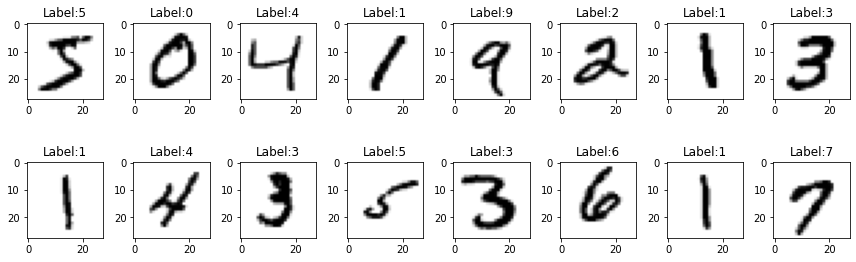

Summarizing the Loaded Dataset
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.002999999932944775.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.00030000000260770325.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 3.000000142492354e-05.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 3.000000106112566e-06.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 3.000000106112566e-07.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 3.000000106112566e-08.
> 99.270


In [52]:
run_main()